In [1]:
# This notebeook is for displaying statistics about the ood dataset split

In [2]:
# load corpus dataset
from src.data.create_corpus_dataset import create_dataset
from src.data.classes import UtteranceType, DatasetConfig, DatasetSplitType
import os
from datasets import load_from_disk
from src.data.dataset_splitting.dataset_splits import create_splits_from_corpus_dataset
from collections import defaultdict
import pandas as pd

# load dataset
dataset_folder = "../../data/processed/with_context"
dataset_path = os.path.join(dataset_folder, "corpus_dataset_v2")

if not os.path.exists(dataset_path):
    # Beispiel zum Erstellen eines Datensatzes. Mögliche Optionen von DatasetConfig sind im DocString beschrieben.
    create_dataset(
        DatasetConfig(
            dataset_path=dataset_path,
            project_dir="../../../",
            num_previous_turns=3,
            include_role=True,
            sep_token="[SEP]",
            utterance_type=UtteranceType.User,
            eval_size=0.5,
            validation_test_ratio=0.5
        )
    )

# Beispiel zum Laden des Datensatzes + collate_function des DataLoaders um dynamisch ein Subset der negative passages zu laden.
corpus_dataset = load_from_disk(dataset_path)

/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from ethikchat_argtoolkit.Dialogue.discussion_szenario import \
    DiscussionSzenario  # Create an Out-of-Distribution (Simple) split
test_scenarios = [DiscussionSzenario.MEDAI, DiscussionSzenario.AUTOAI, DiscussionSzenario.JURAI, DiscussionSzenario.REFAI]
ood_splits = {}
for test_scenario in test_scenarios:
    ood_splits[test_scenario] = create_splits_from_corpus_dataset(corpus_dataset,
                                                      DatasetSplitType.OutOfDistributionHard,
                                                      save_folder=dataset_folder,
                                                      dataset_save_name=f"dataset_split_by_scenario_{test_scenario}",
                                                      test_scenario=test_scenario)
ood_splits[test_scenarios[0]]["train"]["queries"]


Dataset already exists at ../../data/processed/with_context/dataset_split_by_scenario_MEDAI. Loading it.
Dataset already exists at ../../data/processed/with_context/dataset_split_by_scenario_AUTOAI. Loading it.
Dataset already exists at ../../data/processed/with_context/dataset_split_by_scenario_JURAI. Loading it.
Dataset already exists at ../../data/processed/with_context/dataset_split_by_scenario_REFAI. Loading it.


/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/data/dataset_splits.py:112: UserWarning: Overlapping texts between train and test (but no overlapping query ids, so theses are not the same queries): 1
Example texts: ['KI ist guenstiger ']
  warnings.warn(
/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/data/dataset_splits.py:107: UserWarning: Overlapping texts between train and validation (but no overlapping query ids, so theses are not the same anchors): 1
Example texts: ['KI ist guenstiger ']
  warnings.warn(


Dataset({
    features: ['id', 'text', 'labels', 'discussion_scenario', 'context', 'scenario_description', 'scenario_question'],
    num_rows: 1335
})

In [4]:
# Count labels per scenario and split
test_scenario_label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))
for test_scenario in test_scenarios:
    for split in ["train", "validation", "test"]:
        for query in ood_splits[test_scenario][split]["queries"]:
            scenario = query["discussion_scenario"]
            for label in query["labels"]:
                test_scenario_label_counts[test_scenario][split][scenario][label] += 1

# Build dataframe
records = []
for test_scenario, label_counts in test_scenario_label_counts.items():
    for split, split_dict in label_counts.items():
        for scenario, labels in split_dict.items():
            for label, count in labels.items():
                records.append({
                    "test_scenario": test_scenario,
                    "scenario": scenario,
                    "label": label,
                    "split": split,
                    "count": count
                })

dataframe = pd.DataFrame(records)
dataframe

,test_scenario,scenario,label,split,count
0,DiscussionSzenario.MEDAI,JURAI,Z.K2,train,19
1,DiscussionSzenario.MEDAI,JURAI,Z.P1-1,train,40
2,DiscussionSzenario.MEDAI,JURAI,Z.K4,train,13
3,DiscussionSzenario.MEDAI,JURAI,Z.K6-1-1,train,12
4,DiscussionSzenario.MEDAI,JURAI,Z.P4-1,train,21
...,...,...,...,...,...
1030,DiscussionSzenario.REFAI,REFAI,Z.K8-1,test,1
1031,DiscussionSzenario.REFAI,REFAI,Z.K1-1-1-1,test,1
1032,DiscussionSzenario.REFAI,REFAI,Z.P9,test,2
1033,DiscussionSzenario.REFAI,REFAI,Z.K7,test,1


NameError: name 'handles' is not defined

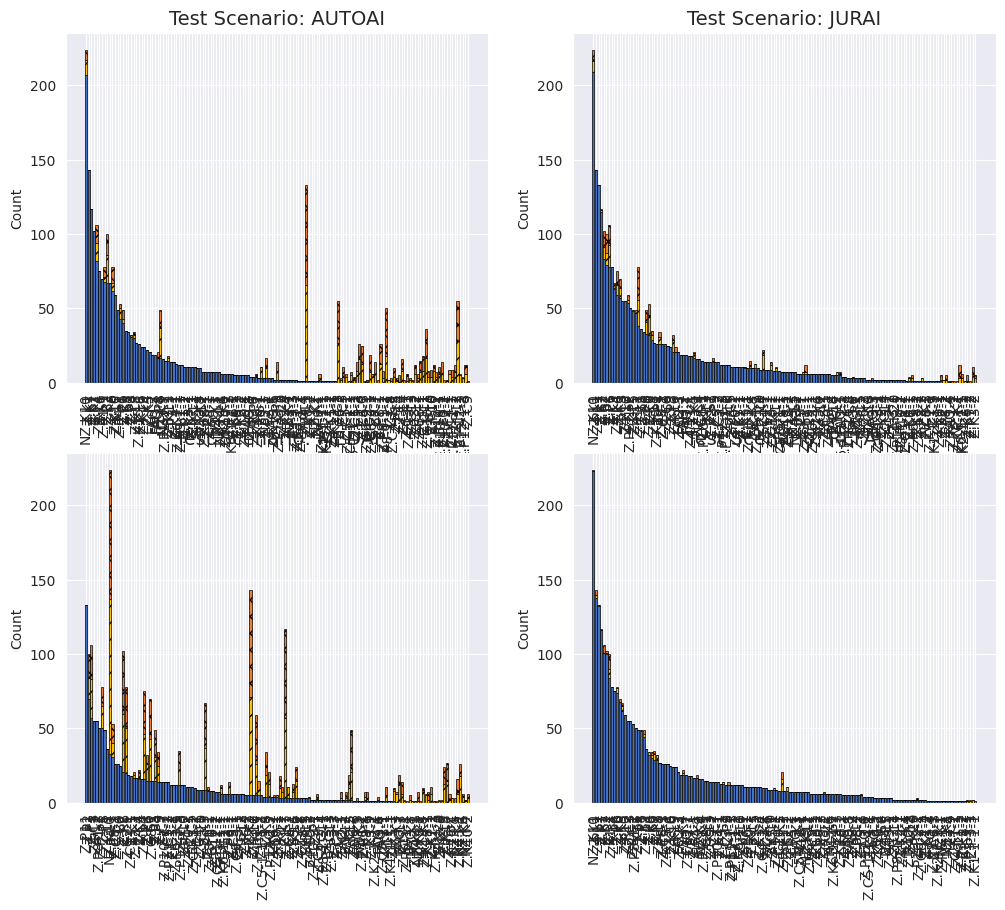

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Setup colors and formatting
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12
})

# Colors for different splits
colors = {"train": "#4472C4", "validation": "#FFC000", "test": "#ED7D31"}
hatches = {"train": "", "validation": "//", "test": "xx"}

# For each test scenario
for i, test_scenario in enumerate(sorted(dataframe["test_scenario"].unique())):
    ax = axes[i]

    # Filter data for this test scenario
    scenario_data = dataframe[dataframe["test_scenario"] == test_scenario]

    # Pivot to get counts by label and split
    pivot_data = scenario_data.pivot_table(
        index="label",
        columns="split",
        values="count",
        aggfunc="sum",
        fill_value=0
    ).sort_values("train", ascending=False)

    # Plot stacked bars
    bottom = np.zeros(len(pivot_data.index))
    for split in ["train", "validation", "test"]:
        if split in pivot_data.columns:
            values = pivot_data[split].values
            bars = ax.bar(pivot_data.index, values, bottom=bottom,
                         label=split, color=colors[split], edgecolor="black", linewidth=0.5)

            # Add hatching
            for bar in bars:
                bar.set_hatch(hatches[split])

            bottom += values

    # Customize appearance
    ax.set_title(f"Test Scenario: {test_scenario}", fontsize=14)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)

    # # Only show legend for the first subplot
    # if i == 0:
    #     handles, labels = ax.get_legend_handles_labels()
    # else:
    #     ax.get_legend().remove()

# Add a single legend for the entire figure
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.savefig("dataset_splits.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# Create summary data showing percentage in each split
summary_data = []
for test_scenario in dataframe["test_scenario"].unique():
    scenario_data = dataframe[dataframe["test_scenario"] == test_scenario]
    total = scenario_data["count"].sum()

    for split in ["train", "validation", "test"]:
        split_count = scenario_data[scenario_data["split"] == split]["count"].sum()
        summary_data.append({
            "test_scenario": test_scenario,
            "split": split,
            "percentage": 100 * split_count / total
        })

summary_df = pd.DataFrame(summary_data)
summary_pivot = summary_df.pivot("test_scenario", "split", "percentage")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(summary_pivot, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={"label": "Percentage of Data"})
plt.title("Distribution of Data Across Splits by Test Scenario")
plt.tight_layout()
plt.savefig("split_distribution.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

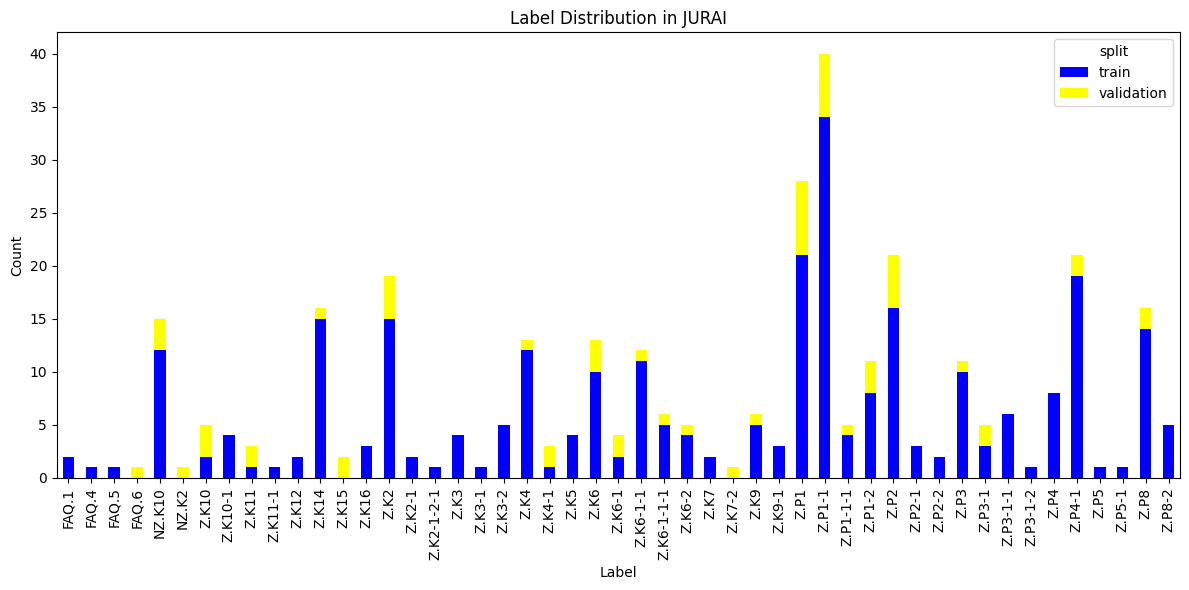

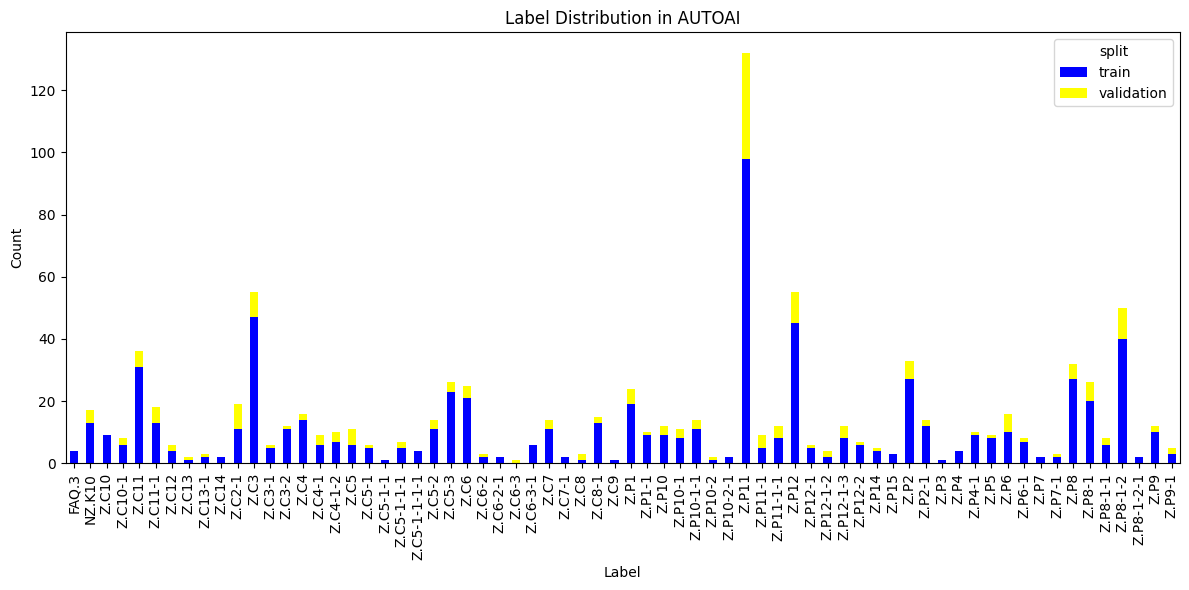

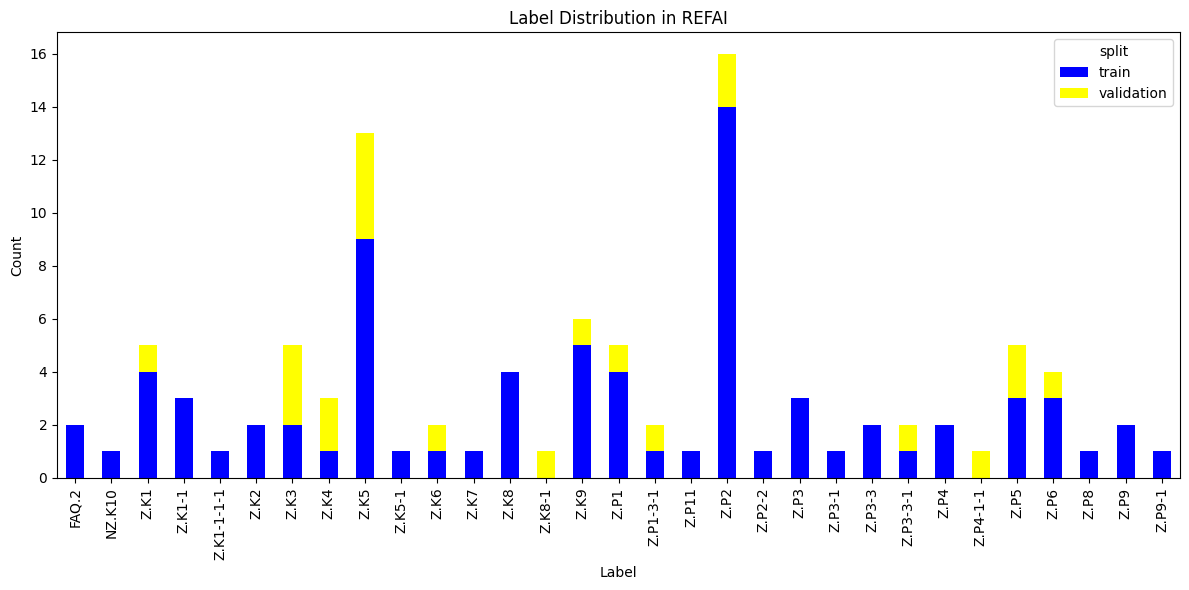

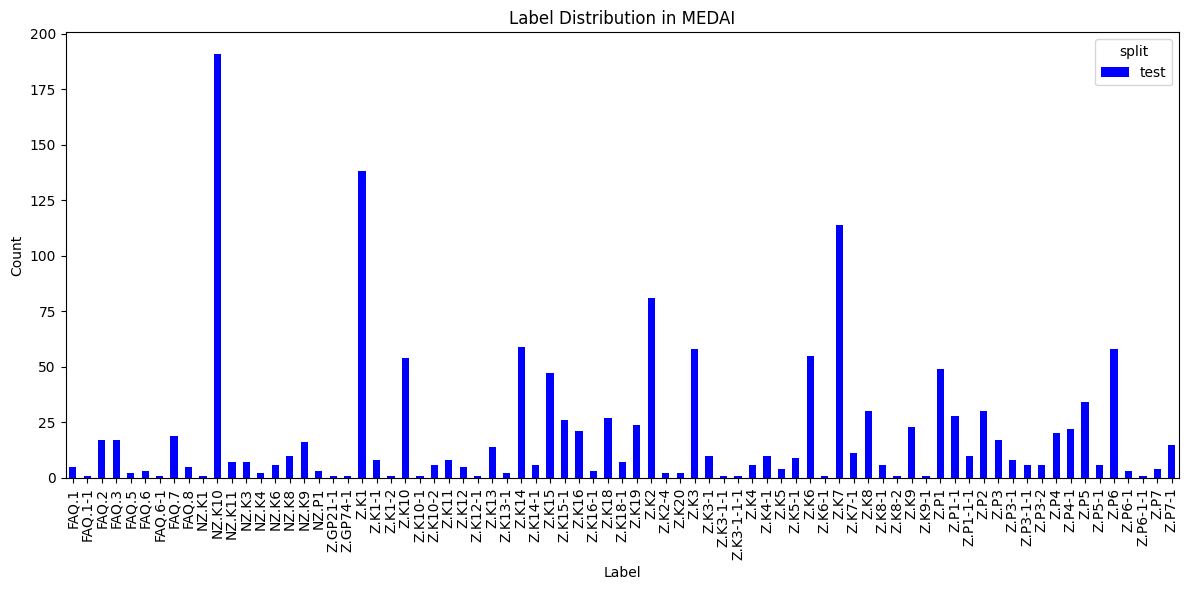

In [8]:
import matplotlib.pyplot as plt

# # Plot stacked bar chart per scenario
scenarios = dataframe["scenario"].unique()
for scenario in scenarios:
    df_scenario = dataframe[dataframe["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0)
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 6))
    plt.title(f"Label Distribution in {scenario}")
    plt.ylabel("Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [9]:
def check_label_distribution(df):
    """
    Checks that any (scenario, label) pair found in 'validation' or 'test'
    also exists in 'train'. If not, prints out the faulty scenario-label pairs.
    Otherwise, confirms that the distribution is valid.
    """
    # Get all (scenario, label) pairs that appear in train (count > 0)
    train_pairs = df[(df["split"] == "train") & (df["count"] > 0)][["scenario", "label"]]
    dis_allowed_pairs = set(zip(train_pairs["scenario"], train_pairs["label"]))

    # Find all pairs in test that have count > 0
    non_train = df[df["split"].isin(["test"]) & (df["count"] > 0)].copy()

    # Mark which of these are allowed
    non_train["is_allowed"] = non_train.apply(
        lambda row: (row["scenario"], row["label"]) not in dis_allowed_pairs, axis=1
    )

    # Collect the ones that are not allowed
    faulty = non_train[~non_train["is_allowed"]]

    if len(faulty) > 0:
        print("Found scenario/label pairs in test that do appear in train:")
        print(faulty[["scenario", "label", "split", "count"]])
    else:
        print("All scenario/label pairs in test are valid (they don't appear in train).")


check_label_distribution(dataframe)

All scenario/label pairs in test are valid (they appear in train).


FileNotFoundError: [Errno 2] No such file or directory: 'paste.txt'